In [1]:
%matplotlib inline

In [2]:
from os import path
import pandas as pd
from skimage.data import imread
from skimage.io import imshow
import numpy as np
import pandas as pd
from numpy.random import randint, seed

In [3]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.optimizers import SGD

Using Theano backend.


Using gpu device 0: GRID K520 (CNMeM is enabled)


In [4]:
nb_img = 256
nb_img_depth = 3

In [5]:
nb_pool = 2
nb_conv = 3
nb_filters = 32
nb_classes = 4

In [7]:
model = Sequential()

model.add(Convolution2D(nb_filters, nb_conv, nb_conv, border_mode='valid', 
                        input_shape=(nb_img_depth, nb_img, nb_img)))
model.add(Activation('relu'))
model.add(Convolution2D(nb_filters, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Convolution2D(64, nb_conv, nb_conv, border_mode='valid'))
model.add(Activation('relu'))
model.add(Convolution2D(64, nb_conv, nb_conv))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.compile(loss='mse', optimizer='sgd')

In [8]:
from transform import load_training, transform_img

In [9]:
training = load_training()

In [10]:
def get_class(fga):
    if fga < 0.1:
        return 0
    elif fga < 0.2:
        return 1
    elif fga < 0.5:
        return 2
    else:
        return 3

In [11]:
training['fga_class'] = training.fga.apply(get_class)

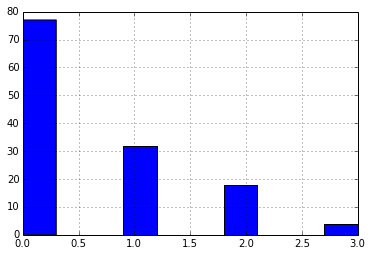

In [12]:
training.fga_class.hist()

In [13]:
training[training.fga_class == 3]

,name,fga,fga_class
1,10549,0.58,3
16,21157,0.66,3
35,30333,0.54,3
40,33088,0.72,3


In [14]:
def transform_pcf(training,
                  output_dir="data-256-patches",
                  patch_size=256):
    patch_num = 0
    for i, row in training.iterrows():
        row_patches = []
        row_output = []
        name = row['name']
        fga = row['fga']
        fga_class = row['fga_class']
        print("Transforming image %s" % name)
        import sys
        sys.stdout.flush()
        for kind in ["DX", "TS"]:
            img = imread("images/%s/%s-%s.png" % (kind, name, kind))
            img_patches = transform_img(img, name, patch_size=patch_size)
            from os import mkdir, path
            class_dir = path.join(output_dir, str(fga_class))
            if not path.exists(class_dir):
                mkdir(class_dir)
            for img_patch in img_patches:
                with open(path.join(output_dir, "%s/patch_file_%s_%d" % (
                            fga_class, name, patch_num)), 'w') as f:
                    np.save(f, img_patch)
                patch_num += 1

In [15]:
# transform_pcf(training)

In [16]:
def get_x_y(training, output_dir="data-256-patches"):
    from os import listdir
    from numpy.random import choice, seed
    seed(1234)
    patches = []
    outputs = []
    for fga_class in sorted(training.fga_class.unique()):
        fga_class = str(fga_class)
        print("Class %s..." % fga_class)
        import sys
        sys.stdout.flush()
        patch_files = choice(listdir(path.join(output_dir, fga_class)), 
                                     size=625, replace=False)
        for patch_file in patch_files:
            patch = np.load(path.join(path.join(output_dir, fga_class), 
                                      patch_file))
            for rot in range(4):
                patches.append(np.rot90(patch, k=rot))
                outputs.append(int(fga_class))
    print("Merging X...")
    sys.stdout.flush()
    X = np.asanyarray(patches)
    print("Merging y...")
    sys.stdout.flush()
    from keras.utils import np_utils
    y = np_utils.to_categorical(outputs)
    return X, y

In [ ]:
X_train, y_train = get_x_y(training)

Class 0...
Class 1...
Class 2...
Class 3...
Merging X...


In [ ]:
X_train = X_train.transpose((0, 3, 2, 1))

In [ ]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=15)

In [ ]:
model.evaluate(X_train, y_train, batch_size=32)